# Installing and importing dependencies

In [1]:
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install tqdm

In [37]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Preparing the dataset - Reading all the images and converting them into an array for data and labels

In [30]:
Datadirectory = "DATASET/1k"
Classes = ["eyeClose1k","eyeOpen1k"]
training_Data = []
img_size = 224

def create_training_Data():
  for category in Classes:
    path = os.path.join(Datadirectory, category)
    class_num = Classes.index(category) #0,1
    for img in tqdm(os.listdir(path),desc=category):
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
        new_array = cv2.resize(backtorgb, (img_size,img_size))
        training_Data.append([new_array,class_num])
      except Exception as e:
        pass

In [7]:
create_training_Data()

eyeOpen1k: 100%|██████████████████████████| 1057/1057 [00:00<00:00, 2987.62it/s]


In [8]:
print(len(training_Data))

2051


In [9]:
import random
random.shuffle(training_Data)

In [10]:
x = []
y = []

for features, label in training_Data:
  x.append(features)
  y.append(label)

x = np.array(x).reshape(-1, img_size, img_size, 3)

In [11]:
x.shape

(2051, 224, 224, 3)

In [12]:
#normalize the data
x=x/255.0;

In [13]:
y=np.array(y)

In [14]:
import pickle

pickle_out = open("x.pickle","wb")
pickle.dump(x,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()



# Model training

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
model = load_model('my_model.h5')

In [32]:
base_input = model.layers[0].input

In [33]:
base_output = model.layers[-4].output

In [34]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)

In [20]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [21]:
new_model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [22]:
new_model.fit(x,y, epochs = 1,validation_split = 0.1)

58/58 [==============================] - 81s 1s/step - loss: 0.1752 - accuracy: 0.9301 - val_loss: 1.6269 - val_accuracy: 0.7524


In [35]:
new_model.save('test2.keras')

# Model testing

## Opened eyes - value > 0.01

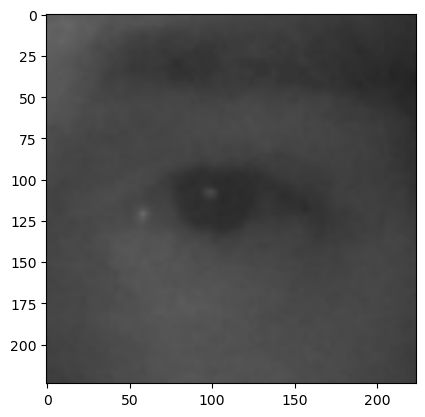

In [38]:
img_array = cv2.imread('DATASET/1k/eyeOpen1k/s0001_01864_0_0_1_0_0_01.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size,img_size))
x_input = np.array(new_array).reshape(1,img_size,img_size, 3)
x_input.shape
plt.imshow(new_array)
x_input = x_input/255.0

In [40]:
new_model = load_model('test2.keras')
prediction = new_model.predict(x_input)
prediction 

1/1 [==============================] - 0s 289ms/step


array([[0.8107094]], dtype=float32)

- if eye is open, value is > 0.01

## Closed eyes - value < 0.01

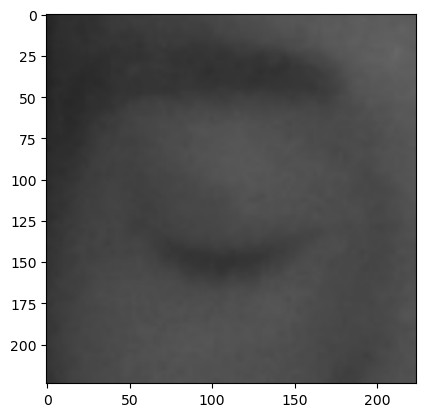

In [183]:
img_array = cv2.imread('DATASET/1k/eyeClose1k/s0001_00001_0_0_0_0_0_01.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size,img_size))
x_input = np.array(new_array).reshape(1,img_size,img_size, 3)
x_input.shape
plt.imshow(new_array)
x_input = x_input/255.0

In [91]:
prediction = new_model.predict(x_input)
prediction

1/1 [==============================] - 0s 36ms/step


array([[0.00752842]], dtype=float32)

- if eye is closed, value < 0.01

## Test with unknown subject

### Using haarcascade to detect eye

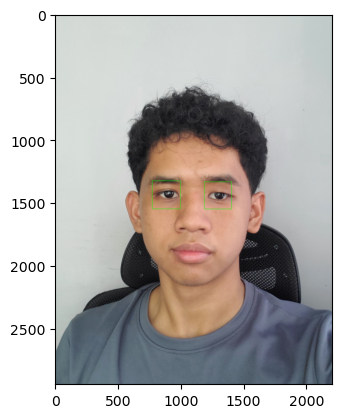

In [262]:
img = cv2.imread('DATASET/Test/open4.jpg')
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
eyes = eyeCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=10)
for(x,y,w,h) in eyes:
    if len(eyes)>2:
        if w>80 and h>80:
            cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
    else:
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

### Cropping the eye image

eye are not detected
eye are not detected


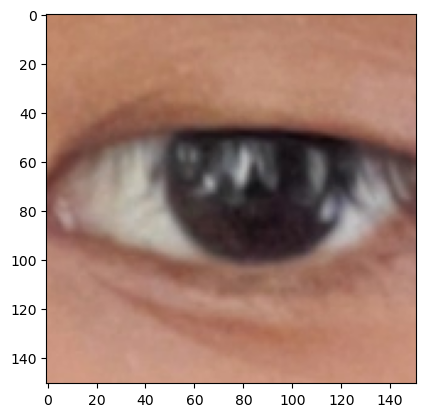

In [289]:
img = cv2.imread('DATASET/Test/open4.jpg')
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
eyes = eyeCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=10)
for(x,y,w,h) in eyes:
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = img[y:y+h,x:x+w]
    eyess = eye_cascade.detectMultiScale(roi_gray)
    if len(eyess) == 0:
        print("eye are not detected")
    else:
        for (ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]
plt.imshow(cv2.cvtColor(eyes_roi,cv2.COLOR_BGR2RGB))

### Standardizing image dimensions, predict with model

In [290]:
eyes_roi.shape

(151, 151, 3)

In [293]:
final_image = cv2.resize(eyes_roi,(224,224))
final_image = np.expand_dims(final_image,axis=0)
final_image = final_image/255.0

In [294]:
final_image.shape

(1, 224, 224, 3)

In [296]:
new_model.predict(final_image)

1/1 [==============================] - 0s 144ms/step


array([[0.9999848]], dtype=float32)

- value is > 0.01 for open eye

# Implementation using webcam

### Testing basic features

In [16]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
new_model = load_model('Test2.keras')
path = 'haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

capture = cv2.VideoCapture(1)

if not capture.isOpened():
    capture = cv2.VideoCapture(0)
if not capture.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = capture.read()
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    eyes_roi = None
    #eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(30, 30))

    for x, y, w, h in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        eyess = eye_cascade.detectMultiScale(roi_gray)
        if len(eyess) == 0:
            print("Eyes are not detected")
        else:
            for (ex, ey, ew, eh) in eyess:
                eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]

    if eyes_roi is not None:
        final_image = cv2.resize(eyes_roi, (224, 224))
        final_image = np.expand_dims(final_image, axis=0)
        final_image = final_image / 255.0

        predictions = new_model.predict(final_image)
        # Set a threshold based on your model's performance
        if predictions > 0.5:
            status = "Eyes are open"
        else:
            status = "Eyes are closed"

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        print(faceCascade.empty())
        faces = faceCascade.detectMultiScale(gray, 1.1, 4)

        # Draw rectangle on faces
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        font = cv2.FONT_HERSHEY_SIMPLEX

        cv2.putText(
            frame,
            status,
            (50, 50),
            font, 3,
            (0, 0, 255),
            2,
            cv2.LINE_4)
        cv2.imshow('Drowsiness Detection', frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

# Release the capture and destroy windows
capture.release()
cv2.destroyAllWindows()

OpenCV: out device of bound (0-0): 1
OpenCV: camera failed to properly initialize!


1/1 [==============================] - 0s 321ms/step
False
1/1 [==============================] - 0s 53ms/step
False
1/1 [==============================] - 0s 45ms/step
False
1/1 [==============================] - 0s 66ms/step
False
1/1 [==============================] - 0s 72ms/step
False
1/1 [==============================] - 0s 45ms/step
False
1/1 [==============================] - 0s 40ms/step
False
1/1 [==============================] - 0s 38ms/step
False
1/1 [==============================] - 0s 41ms/step
False
1/1 [==============================] - 0s 42ms/step
False
1/1 [==============================] - 0s 48ms/step
False
1/1 [==============================] - 0s 44ms/step
False
1/1 [==============================] - 0s 43ms/step
False
1/1 [==============================] - 0s 38ms/step
False
1/1 [==============================] - 0s 45ms/step
False
1/1 [==============================] - 0s 41ms/step
False
1/1 [==============================] - 0s 43ms/step
False
1/1 [========

### Adding feature: If eye is closed for more than 1 second, alarm sound will be generated

In [19]:
!pip install pygame

  Obtaining dependency information for pygame from https://files.pythonhosted.org/packages/4d/84/5a03c47c76020c4f46354cf8c3f2d7926592c1ff9370f0ad91a3bb577b54/pygame-2.5.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 2.0 MB/s eta 0:00:0000:0100:01


In [26]:
from tensorflow.keras.models import load_model
import os
import cv2
import numpy as np
from datetime import datetime, timedelta
import pygame

new_model = load_model('Test2.keras')
path = 'haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

capture = cv2.VideoCapture(1)

if not capture.isOpened():
    capture = cv2.VideoCapture(0)
if not capture.isOpened():
    raise IOError("Cannot open webcam")

counter = 0  # Initialize the counter
alert_start_time = None  # Initialize the time when alert started

# Initialize pygame mixer
pygame.mixer.init()

while True:
    ret, frame = capture.read()
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    eyes_roi = None
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(30, 30))

    for x, y, w, h in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        eyess = eye_cascade.detectMultiScale(roi_gray)
        if len(eyess) == 0:
            print("Eyes are not detected")
        else:
            for (ex, ey, ew, eh) in eyess:
                eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]

    if eyes_roi is not None:
        final_image = cv2.resize(eyes_roi, (224, 224))
        final_image = np.expand_dims(final_image, axis=0)
        final_image = final_image / 255.0

        predictions = new_model.predict(final_image)
        # Set a threshold based on your model's performance
        if predictions > 0.5:
            status = "Eyes are open"
            color = (0, 255, 0)  # Green
            if alert_start_time is not None:
                alert_start_time = None  # Reset the timer if eyes are open
        else:
            counter = counter + 1
            status = "Eyes are closed"
            color = (0, 0, 255)  # Red
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

            if counter > 5:
                if alert_start_time is None:
                    alert_start_time = datetime.now()  # Start the timer
                else:
                    time_elapsed = datetime.now() - alert_start_time
                    if time_elapsed.total_seconds() >= 1:
                        x1, y1, w1, h1 = 0, 0, 175, 75
                        cv2.rectangle(frame, (x1, y1), (x1+w1, y1+h1), (0, 0, 0), -1)
                        cv2.putText(frame, 'Sleep Alert!', (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                        # Use pygame mixer to play the sound
                        pygame.mixer.music.load("sleepAlertSound.mp3")
                        pygame.mixer.music.play()
                        counter = 0
                        alert_start_time = None  # Reset the timer after alert

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        print(faceCascade.empty())
        faces = faceCascade.detectMultiScale(gray, 1.1, 4)

        # Draw rectangle on faces
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        font = cv2.FONT_HERSHEY_SIMPLEX

        cv2.putText(
            frame,
            status,
            (50, 50),
            font, 3,
            color,  # Use the determined color
            2,
            cv2.LINE_4)

        cv2.imshow('Drowsiness Detection', frame)

    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

# Release the capture and destroy windows
capture.release()
cv2.destroyAllWindows()


OpenCV: out device of bound (0-0): 1
OpenCV: camera failed to properly initialize!


1/1 [==============================] - 0s 337ms/step
False
1/1 [==============================] - 0s 50ms/step
False
1/1 [==============================] - 0s 52ms/step
False
1/1 [==============================] - 0s 56ms/step
False
1/1 [==============================] - 0s 56ms/step
False
1/1 [==============================] - 0s 38ms/step
False
1/1 [==============================] - 0s 40ms/step
False
1/1 [==============================] - 0s 44ms/step
False
1/1 [==============================] - 0s 39ms/step
False
1/1 [==============================] - 0s 41ms/step
False
1/1 [==============================] - 0s 43ms/step
False
1/1 [==============================] - 0s 41ms/step
False
1/1 [==============================] - 0s 42ms/step
False
1/1 [==============================] - 0s 39ms/step
False
1/1 [==============================] - 0s 35ms/step
False
1/1 [==============================] - 0s 43ms/step
False
1/1 [==============================] - 0s 42ms/step
False
1/1 [========

1/1 [==============================] - 0s 38ms/step
False
1/1 [==============================] - 0s 39ms/step
False
1/1 [==============================] - 0s 42ms/step
False
1/1 [==============================] - 0s 42ms/step
False
1/1 [==============================] - 0s 43ms/step
False
1/1 [==============================] - 0s 41ms/step
False
1/1 [==============================] - 0s 45ms/step
False
Eyes are not detected
1/1 [==============================] - 0s 45ms/step
False
1/1 [==============================] - 0s 43ms/step
False
1/1 [==============================] - 0s 44ms/step
False
1/1 [==============================] - 0s 47ms/step
False
1/1 [==============================] - 0s 34ms/step
False
1/1 [==============================] - 0s 42ms/step
False
1/1 [==============================] - 0s 43ms/step
False
1/1 [==============================] - 0s 46ms/step
False
